<a href="https://colab.research.google.com/github/anonymous-ait/green_forecast_visualization/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [3]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.9 MB/s eta 0:00:00


In [4]:
import os
import math

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance,plot_tree
plt.style.use('fivethirtyeight')
from sklearn.model_selection import GridSearchCV
import pylab 

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import boxcox, inv_boxcox
from scipy import stats
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('train_IxoE5JN.csv')
test  = pd.read_csv('test_WudNWDM.csv')
submission = pd.read_csv('002.csv')

In [6]:
print(train)
print(test)
submission

       row_id             datetime       energy
0           1  2008-03-01 00:00:00  1259.985563
1           2  2008-03-01 01:00:00  1095.541500
2           3  2008-03-01 02:00:00  1056.247500
3           4  2008-03-01 03:00:00  1034.742000
4           5  2008-03-01 04:00:00  1026.334500
...       ...                  ...          ...
94987   94988  2018-12-31 19:00:00  2528.446800
94988   94989  2018-12-31 20:00:00  2461.883600
94989   94990  2018-12-31 21:00:00  2365.994400
94990   94991  2018-12-31 22:00:00  2342.942800
94991   94992  2018-12-31 23:00:00  2180.217600

[94992 rows x 3 columns]
       row_id             datetime
0       94993  2019-01-01 00:00:00
1       94994  2019-01-01 01:00:00
2       94995  2019-01-01 02:00:00
3       94996  2019-01-01 03:00:00
4       94997  2019-01-01 04:00:00
...       ...                  ...
26299  121292  2021-12-31 19:00:00
26300  121293  2021-12-31 20:00:00
26301  121294  2021-12-31 21:00:00
26302  121295  2021-12-31 22:00:00
26303  121296

,row_id,energy
0,94993,1702.995014
1,94994,1702.995014
2,94995,1702.995014
3,94996,1702.995014
4,94997,1702.995014
...,...,...
26299,121292,1702.995014
26300,121293,1702.995014
26301,121294,1702.995014
26302,121295,1702.995014


In [7]:
print("Training data shape : ",train.shape)
print("Test data shape : ",test.shape)

Training data shape :  (94992, 3)
Test data shape :  (26304, 2)


In [8]:
train.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

In [9]:
test.isnull().sum()

row_id      0
datetime    0
dtype: int64

In [10]:
train['energy']= train['energy'].replace(0,train['energy'].mean())

In [11]:
df1 = train.isnull().sum()

In [12]:
train.describe()

,row_id,energy
count,94992.000000,93092.000000
mean,47496.500000,1702.995014
std,27421.972723,369.322103
min,1.000000,866.388600
25%,23748.750000,1431.541100
50%,47496.500000,1654.465800
75%,71244.250000,1935.993450
max,94992.000000,3374.399600


In [13]:
tr = pd.isna(train['energy']).count
tr

<bound method Series.count of 0        False
1        False
2        False
3        False
4        False
         ...  
94987    False
94988    False
94989    False
94990    False
94991    False
Name: energy, Length: 94992, dtype: bool>

In [14]:
train.datetime
print(test.datetime)

0        2019-01-01 00:00:00
1        2019-01-01 01:00:00
2        2019-01-01 02:00:00
3        2019-01-01 03:00:00
4        2019-01-01 04:00:00
                ...         
26299    2021-12-31 19:00:00
26300    2021-12-31 20:00:00
26301    2021-12-31 21:00:00
26302    2021-12-31 22:00:00
26303    2021-12-31 23:00:00
Name: datetime, Length: 26304, dtype: object


In [15]:
train['date'] = pd.to_datetime(train['datetime']).dt.date
train['Hour'] = pd.to_datetime(train['datetime']).dt.hour
print(train)
print(train.dtypes)

       row_id             datetime       energy        date  Hour
0           1  2008-03-01 00:00:00  1259.985563  2008-03-01     0
1           2  2008-03-01 01:00:00  1095.541500  2008-03-01     1
2           3  2008-03-01 02:00:00  1056.247500  2008-03-01     2
3           4  2008-03-01 03:00:00  1034.742000  2008-03-01     3
4           5  2008-03-01 04:00:00  1026.334500  2008-03-01     4
...       ...                  ...          ...         ...   ...
94987   94988  2018-12-31 19:00:00  2528.446800  2018-12-31    19
94988   94989  2018-12-31 20:00:00  2461.883600  2018-12-31    20
94989   94990  2018-12-31 21:00:00  2365.994400  2018-12-31    21
94990   94991  2018-12-31 22:00:00  2342.942800  2018-12-31    22
94991   94992  2018-12-31 23:00:00  2180.217600  2018-12-31    23

[94992 rows x 5 columns]
row_id        int64
datetime     object
energy      float64
date         object
Hour          int64
dtype: object


In [16]:
test['date'] = pd.to_datetime(test['datetime']).dt.date
test['Hour'] = pd.to_datetime(test['datetime']).dt.hour
print(test)
print(test.dtypes)

       row_id             datetime        date  Hour
0       94993  2019-01-01 00:00:00  2019-01-01     0
1       94994  2019-01-01 01:00:00  2019-01-01     1
2       94995  2019-01-01 02:00:00  2019-01-01     2
3       94996  2019-01-01 03:00:00  2019-01-01     3
4       94997  2019-01-01 04:00:00  2019-01-01     4
...       ...                  ...         ...   ...
26299  121292  2021-12-31 19:00:00  2021-12-31    19
26300  121293  2021-12-31 20:00:00  2021-12-31    20
26301  121294  2021-12-31 21:00:00  2021-12-31    21
26302  121295  2021-12-31 22:00:00  2021-12-31    22
26303  121296  2021-12-31 23:00:00  2021-12-31    23

[26304 rows x 4 columns]
row_id       int64
datetime    object
date        object
Hour         int64
dtype: object


In [17]:
df = train.copy()
df

,row_id,datetime,energy,date,Hour
0,1,2008-03-01 00:00:00,1259.985563,2008-03-01,0
1,2,2008-03-01 01:00:00,1095.541500,2008-03-01,1
2,3,2008-03-01 02:00:00,1056.247500,2008-03-01,2
3,4,2008-03-01 03:00:00,1034.742000,2008-03-01,3
4,5,2008-03-01 04:00:00,1026.334500,2008-03-01,4
...,...,...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800,2018-12-31,19
94988,94989,2018-12-31 20:00:00,2461.883600,2018-12-31,20
94989,94990,2018-12-31 21:00:00,2365.994400,2018-12-31,21
94990,94991,2018-12-31 22:00:00,2342.942800,2018-12-31,22


In [18]:
df_filter = df.isin([np.nan, np.inf, -np.inf])
  
# Masking df with the filter
df = df[~df_filter]
  
# Dropping rows with nan values
df.dropna(inplace=True)
  
# Printing df
df

,row_id,datetime,energy,date,Hour
0,1,2008-03-01 00:00:00,1259.985563,2008-03-01,0
1,2,2008-03-01 01:00:00,1095.541500,2008-03-01,1
2,3,2008-03-01 02:00:00,1056.247500,2008-03-01,2
3,4,2008-03-01 03:00:00,1034.742000,2008-03-01,3
4,5,2008-03-01 04:00:00,1026.334500,2008-03-01,4
...,...,...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800,2018-12-31,19
94988,94989,2018-12-31 20:00:00,2461.883600,2018-12-31,20
94989,94990,2018-12-31 21:00:00,2365.994400,2018-12-31,21
94990,94991,2018-12-31 22:00:00,2342.942800,2018-12-31,22


In [19]:
df.dtypes

row_id        int64
datetime     object
energy      float64
date         object
Hour          int64
dtype: object

In [20]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['is_quarter_date'] = df['date'].apply(lambda x: x.quarter)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

df.drop(['date'], axis=1, inplace=True)

In [21]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].apply(lambda x: x.year)
test['month'] = test['date'].apply(lambda x: x.month)
test['day'] = test['date'].apply(lambda x: x.day)
test['day_of_week'] = test['date'].apply(lambda x: x.dayofweek)
test['is_quarter_date'] = test['date'].apply(lambda x: x.quarter)
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x>4 else 0)

test.drop(['date'], axis=1, inplace=True)

In [22]:
test

,row_id,datetime,Hour,year,month,day,day_of_week,is_quarter_date,is_weekend
0,94993,2019-01-01 00:00:00,0,2019,1,1,1,1,0
1,94994,2019-01-01 01:00:00,1,2019,1,1,1,1,0
2,94995,2019-01-01 02:00:00,2,2019,1,1,1,1,0
3,94996,2019-01-01 03:00:00,3,2019,1,1,1,1,0
4,94997,2019-01-01 04:00:00,4,2019,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
26299,121292,2021-12-31 19:00:00,19,2021,12,31,4,4,0
26300,121293,2021-12-31 20:00:00,20,2021,12,31,4,4,0
26301,121294,2021-12-31 21:00:00,21,2021,12,31,4,4,0
26302,121295,2021-12-31 22:00:00,22,2021,12,31,4,4,0


In [23]:
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'
    
df['Type_of_Day'] = df['Hour'].apply(lambda x: time_of_day(x))

In [24]:
df

,row_id,datetime,energy,Hour,year,month,day,day_of_week,is_quarter_date,is_weekend,Type_of_Day
0,1,2008-03-01 00:00:00,1259.985563,0,2008,3,1,5,1,1,Night
1,2,2008-03-01 01:00:00,1095.541500,1,2008,3,1,5,1,1,Late Night
2,3,2008-03-01 02:00:00,1056.247500,2,2008,3,1,5,1,1,Late Night
3,4,2008-03-01 03:00:00,1034.742000,3,2008,3,1,5,1,1,Late Night
4,5,2008-03-01 04:00:00,1026.334500,4,2008,3,1,5,1,1,Early Morning
...,...,...,...,...,...,...,...,...,...,...,...
94987,94988,2018-12-31 19:00:00,2528.446800,19,2018,12,31,0,4,0,Evening
94988,94989,2018-12-31 20:00:00,2461.883600,20,2018,12,31,0,4,0,Evening
94989,94990,2018-12-31 21:00:00,2365.994400,21,2018,12,31,0,4,0,Night
94990,94991,2018-12-31 22:00:00,2342.942800,22,2018,12,31,0,4,0,Night


In [25]:
test['Type_of_Day'] = test['Hour'].apply(lambda x: time_of_day(x))

In [26]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

df['Season'] = df['month'].apply(month2seasons)
test['Season'] = test['month'].apply(month2seasons)

In [27]:
print(df)
print(test)

       row_id             datetime       energy  Hour  year  month  day  \
0           1  2008-03-01 00:00:00  1259.985563     0  2008      3    1   
1           2  2008-03-01 01:00:00  1095.541500     1  2008      3    1   
2           3  2008-03-01 02:00:00  1056.247500     2  2008      3    1   
3           4  2008-03-01 03:00:00  1034.742000     3  2008      3    1   
4           5  2008-03-01 04:00:00  1026.334500     4  2008      3    1   
...       ...                  ...          ...   ...   ...    ...  ...   
94987   94988  2018-12-31 19:00:00  2528.446800    19  2018     12   31   
94988   94989  2018-12-31 20:00:00  2461.883600    20  2018     12   31   
94989   94990  2018-12-31 21:00:00  2365.994400    21  2018     12   31   
94990   94991  2018-12-31 22:00:00  2342.942800    22  2018     12   31   
94991   94992  2018-12-31 23:00:00  2180.217600    23  2018     12   31   

       day_of_week  is_quarter_date  is_weekend    Type_of_Day  Season  
0                5        

In [28]:
df['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
df['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

In [29]:
test['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
test['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

<Axes: xlabel='Hour', ylabel='energy'>

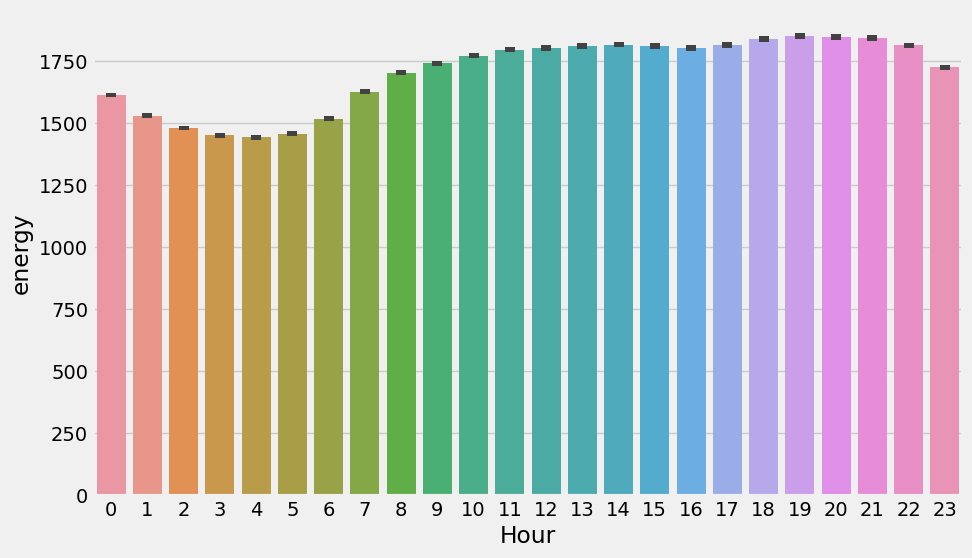

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Hour'], y=df['energy'])

<Axes: xlabel='Season', ylabel='energy'>

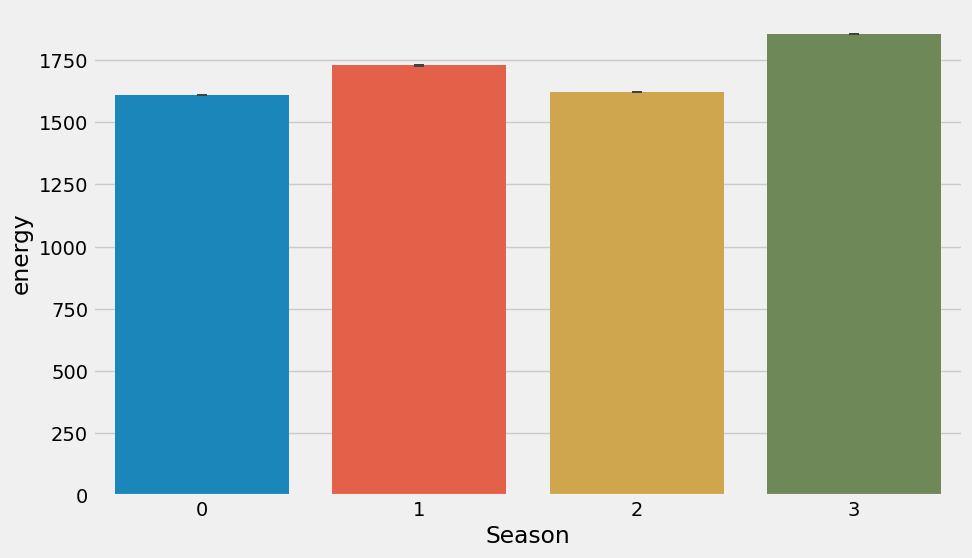

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Season'], y=df['energy'])

<Axes: xlabel='Type_of_Day', ylabel='energy'>

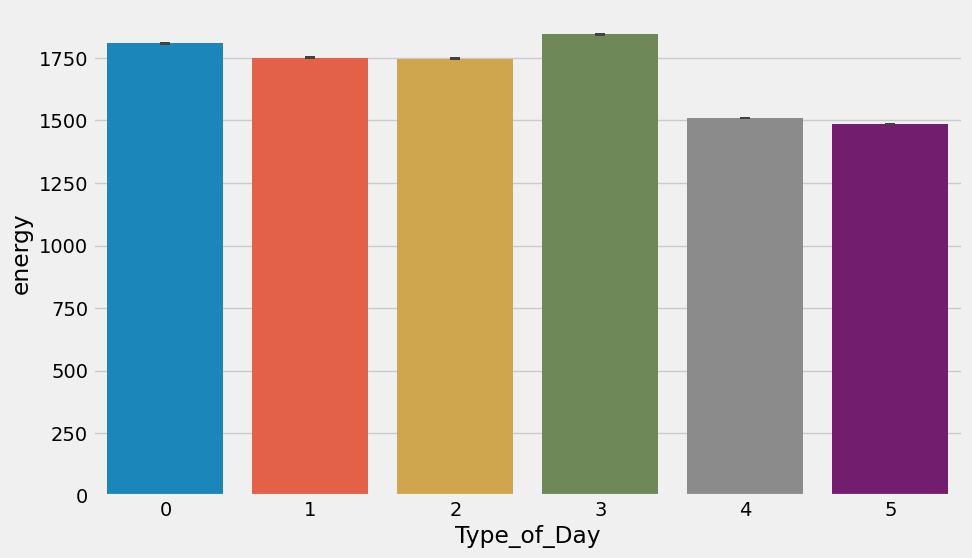

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['Type_of_Day'], y=df['energy'])

<Axes: xlabel='year', ylabel='energy'>

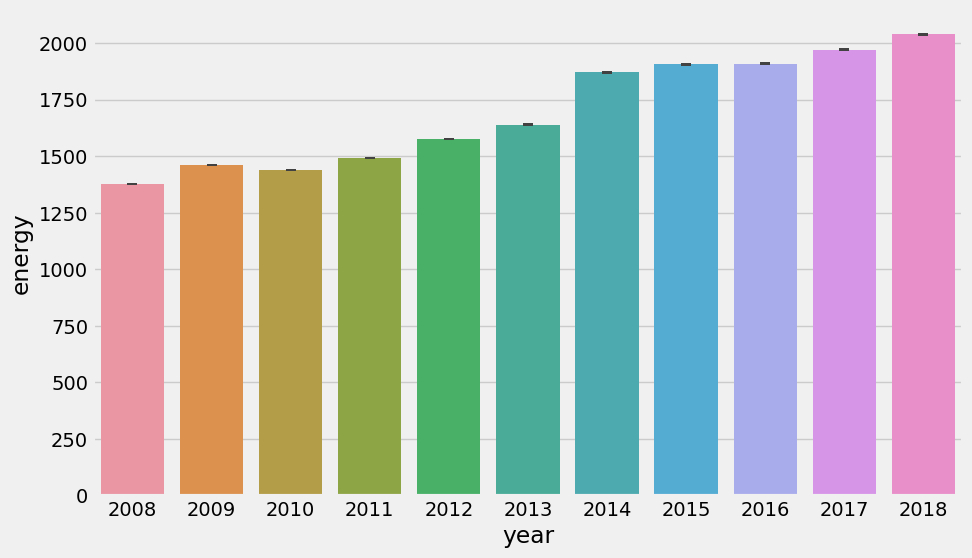

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['year'], y=df['energy'])

In [34]:
y = df['energy'].copy()
X = df.drop('energy', axis=1).copy()

In [35]:
X['hour_sin'] = np.sin(X['Hour']*(2.*np.pi/24))
X['hour_cos'] = np.cos(X['Hour']*(2.*np.pi/24))
X['month_sin'] = np.sin((X['month']-1)*(2.*np.pi/12))
X['month_cos'] = np.cos((X['month']-1)*(2.*np.pi/12))

X['day_of_week'] = np.cos(X['day_of_week'])

X.drop(['Hour', 'month'], axis=1, inplace=True)

In [36]:
test['hour_sin'] = np.sin(test['Hour']*(2.*np.pi/24))
test['hour_cos'] = np.cos(test['Hour']*(2.*np.pi/24))
test['month_sin'] = np.sin((test['month']-1)*(2.*np.pi/12))
test['month_cos'] = np.cos((test['month']-1)*(2.*np.pi/12))

test['day_of_week'] = np.cos(test['day_of_week'])

test.drop(['Hour', 'month'], axis=1, inplace=True)

In [37]:
X.round(decimals=2)

,row_id,datetime,year,day,day_of_week,is_quarter_date,is_weekend,Type_of_Day,Season,hour_sin,hour_cos,month_sin,month_cos
0,1,2008-03-01 00:00:00,2008,1,0.28,1,1,2,2,0.00,1.00,0.87,0.50
1,2,2008-03-01 01:00:00,2008,1,0.28,1,1,5,2,0.26,0.97,0.87,0.50
2,3,2008-03-01 02:00:00,2008,1,0.28,1,1,5,2,0.50,0.87,0.87,0.50
3,4,2008-03-01 03:00:00,2008,1,0.28,1,1,5,2,0.71,0.71,0.87,0.50
4,5,2008-03-01 04:00:00,2008,1,0.28,1,1,4,2,0.87,0.50,0.87,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94987,94988,2018-12-31 19:00:00,2018,31,1.00,4,0,3,1,-0.97,0.26,-0.50,0.87
94988,94989,2018-12-31 20:00:00,2018,31,1.00,4,0,3,1,-0.87,0.50,-0.50,0.87
94989,94990,2018-12-31 21:00:00,2018,31,1.00,4,0,2,1,-0.71,0.71,-0.50,0.87
94990,94991,2018-12-31 22:00:00,2018,31,1.00,4,0,2,1,-0.50,0.87,-0.50,0.87


In [38]:
test.round(decimals = 2)

,row_id,datetime,year,day,day_of_week,is_quarter_date,is_weekend,Type_of_Day,Season,hour_sin,hour_cos,month_sin,month_cos
0,94993,2019-01-01 00:00:00,2019,1,0.54,1,0,2,1,0.00,1.00,0.0,1.00
1,94994,2019-01-01 01:00:00,2019,1,0.54,1,0,5,1,0.26,0.97,0.0,1.00
2,94995,2019-01-01 02:00:00,2019,1,0.54,1,0,5,1,0.50,0.87,0.0,1.00
3,94996,2019-01-01 03:00:00,2019,1,0.54,1,0,5,1,0.71,0.71,0.0,1.00
4,94997,2019-01-01 04:00:00,2019,1,0.54,1,0,4,1,0.87,0.50,0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,121292,2021-12-31 19:00:00,2021,31,-0.65,4,0,3,1,-0.97,0.26,-0.5,0.87
26300,121293,2021-12-31 20:00:00,2021,31,-0.65,4,0,3,1,-0.87,0.50,-0.5,0.87
26301,121294,2021-12-31 21:00:00,2021,31,-0.65,4,0,2,1,-0.71,0.71,-0.5,0.87
26302,121295,2021-12-31 22:00:00,2021,31,-0.65,4,0,2,1,-0.50,0.87,-0.5,0.87


In [39]:
vif_info = pd.DataFrame()

In [40]:
X = X.drop('datetime' ,axis= 1)

In [41]:
X.dtypes

row_id               int64
year                 int64
day                  int64
day_of_week        float64
is_quarter_date      int64
is_weekend           int64
Type_of_Day          int64
Season               int64
hour_sin           float64
hour_cos           float64
month_sin          float64
month_cos          float64
dtype: object

In [42]:
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
1,33.123057,year
4,18.452855,is_quarter_date
6,8.638707,Type_of_Day
7,8.311279,Season
2,4.193170,day
0,4.036494,row_id
10,3.849562,month_sin
9,2.707700,hour_cos
11,2.075886,month_cos
5,1.746682,is_weekend


In [43]:
vif_info.round(decimals = 2)

,VIF,Columns
0,4.04,row_id
1,33.12,year
2,4.19,day
3,1.27,day_of_week
4,18.45,is_quarter_date
5,1.75,is_weekend
6,8.64,Type_of_Day
7,8.31,Season
8,1.70,hour_sin
9,2.71,hour_cos


In [44]:
test.dtypes
print(test)

       row_id             datetime  year  day  day_of_week  is_quarter_date  \
0       94993  2019-01-01 00:00:00  2019    1     0.540302                1   
1       94994  2019-01-01 01:00:00  2019    1     0.540302                1   
2       94995  2019-01-01 02:00:00  2019    1     0.540302                1   
3       94996  2019-01-01 03:00:00  2019    1     0.540302                1   
4       94997  2019-01-01 04:00:00  2019    1     0.540302                1   
...       ...                  ...   ...  ...          ...              ...   
26299  121292  2021-12-31 19:00:00  2021   31    -0.653644                4   
26300  121293  2021-12-31 20:00:00  2021   31    -0.653644                4   
26301  121294  2021-12-31 21:00:00  2021   31    -0.653644                4   
26302  121295  2021-12-31 22:00:00  2021   31    -0.653644                4   
26303  121296  2021-12-31 23:00:00  2021   31    -0.653644                4   

       is_weekend  Type_of_Day  Season  hour_sin  h

In [45]:
X.drop(['year', 'is_quarter_date'], axis=1, inplace=True)

In [46]:
test.drop(['datetime', 'year', 'is_quarter_date'], axis=1, inplace=True)

In [47]:
y.isnull().sum()

0

In [48]:
print(X)
print(vif_info)

       row_id  day  day_of_week  is_weekend  Type_of_Day  Season  hour_sin  \
0           1    1     0.283662           1            2       2  0.000000   
1           2    1     0.283662           1            5       2  0.258819   
2           3    1     0.283662           1            5       2  0.500000   
3           4    1     0.283662           1            5       2  0.707107   
4           5    1     0.283662           1            4       2  0.866025   
...       ...  ...          ...         ...          ...     ...       ...   
94987   94988   31     1.000000           0            3       1 -0.965926   
94988   94989   31     1.000000           0            3       1 -0.866025   
94989   94990   31     1.000000           0            2       1 -0.707107   
94990   94991   31     1.000000           0            2       1 -0.500000   
94991   94992   31     1.000000           0            2       1 -0.258819   

       hour_cos  month_sin  month_cos  
0      1.000000   0.866

In [49]:
vif_info_afterdrop = pd.DataFrame()
vif_info_afterdrop['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info_afterdrop['Columns'] = X.columns
vif_info_afterdrop.sort_values('VIF', ascending=False)

,VIF,Columns
4,6.115666,Type_of_Day
5,5.938257,Season
1,3.484628,day
0,3.357730,row_id
7,2.208545,hour_cos
8,1.726466,month_sin
3,1.707404,is_weekend
9,1.699370,month_cos
6,1.494291,hour_sin
2,1.269792,day_of_week


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import Lasso, LinearRegression
from lightgbm import LGBMRegressor

In [51]:
X.values.round(decimals = 2)

array([[ 1.0000e+00,  1.0000e+00,  2.8000e-01, ...,  1.0000e+00,
         8.7000e-01,  5.0000e-01],
       [ 2.0000e+00,  1.0000e+00,  2.8000e-01, ...,  9.7000e-01,
         8.7000e-01,  5.0000e-01],
       [ 3.0000e+00,  1.0000e+00,  2.8000e-01, ...,  8.7000e-01,
         8.7000e-01,  5.0000e-01],
       ...,
       [ 9.4990e+04,  3.1000e+01,  1.0000e+00, ...,  7.1000e-01,
        -5.0000e-01,  8.7000e-01],
       [ 9.4991e+04,  3.1000e+01,  1.0000e+00, ...,  8.7000e-01,
        -5.0000e-01,  8.7000e-01],
       [ 9.4992e+04,  3.1000e+01,  1.0000e+00, ...,  9.7000e-01,
        -5.0000e-01,  8.7000e-01]])

In [52]:
z = (train['energy'].count() - train['energy'].mean()) / train['energy'].std()
z

247.45067850651392

In [53]:
y = y - z
y.round(decimals=2)

0        1012.53
1         848.09
2         808.80
3         787.29
4         778.88
          ...   
94987    2281.00
94988    2214.43
94989    2118.54
94990    2095.49
94991    1932.77
Name: energy, Length: 93092, dtype: float64

In [54]:
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [55]:
encoded_y

array([ 7067,  1762,  1038, ..., 57059, 56677, 53101])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, train_size=0.7, random_state=21)

In [57]:
X_test = X_test.round(decimals = 2)

In [58]:
X_train = X_train.round(decimals = 2)

In [59]:
y_test = y_test.round(decimals=2)

In [60]:
y_train = y_train.round(decimals =2)

In [61]:
models = {
    'Linear Regression(Ridge)' : Ridge(),
    '          Neural Network' : MLPRegressor(),
    '           Random Forest' : RandomForestRegressor(),
    '                Catboost' : CatBoostRegressor(verbose=0),
    '       XGBoost Regressor' : XGBRegressor(),
    '    XGBoost RF Regressor' : XGBRFRegressor(),
    'Linear Regression(lasso)' : Lasso(),
    '       Linear Regression' : LinearRegression(),
    ' Light Gradient Boosting' : LGBMRegressor()
}

for name, models in models.items():
    models.fit(X_train, y_train)
    print(name + ' trained.')

Linear Regression(Ridge) trained.
          Neural Network trained.
           Random Forest trained.
                Catboost trained.
       XGBoost Regressor trained.
    XGBoost RF Regressor trained.
Linear Regression(lasso) trained.
       Linear Regression trained.
 Light Gradient Boosting trained.


In [62]:
def get_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    return rmse

In [63]:
def get_r2(y_test, y_pred):
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
    return r2

In [64]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
lgbm_rmse = mse(y_test, lgbm_pred, squared=False)
print(lgbm_rmse)

115.91114850249082


In [65]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = mse(y_test, lr_pred, squared=False)
print(lr_rmse)

236.55631046958422


In [66]:
lr_lasso = Lasso()
lr_lasso.fit(X_train, y_train)
lr_lasso_pred = lr_lasso.predict(X_test)
lr_lasso_rmse = mse(y_test, lr_lasso_pred, squared=False)
print(lr_lasso_rmse)

236.6827873312044


In [67]:
XGRF = XGBRFRegressor()
XGRF.fit(X_train,y_train)
XGRF_pred = XGRF.predict(X_test)
XGRF_rmse = mse(y_test, XGRF_pred, squared=False)
print(XGRF_rmse)

180.55420891288003


In [68]:
XGBRF = XGBRegressor()
XGBRF.fit(X_train,y_train)
XGBRF_pred = XGBRF.predict(X_test)
XGBRF_rmse = mse(y_test, XGBRF_pred, squared=False)
print(XGBRF_rmse)

74.80760682424643


In [69]:
Cat = CatBoostRegressor(verbose=0)
Cat.fit(X_train,y_train)
Cat_pred = Cat.predict(X_test)
Cat_rmse = mse(y_test, Cat_pred, squared=False)
print(Cat_rmse)

87.858375818608


In [70]:
RF = RandomForestRegressor()
RF.fit(X_train,y_train)
RF_pred = RF.predict(X_test)
RF_rmse = mse(y_test, RF_pred, squared=False)
print(RF_rmse)

52.214435007101564


In [71]:
NN = MLPRegressor()
NN.fit(X_train,y_train)
NN_pred = NN.predict(X_test)
NN_rmse = mse(y_test, NN_pred, squared=False)
print(NN_rmse)

292.5260776581168


In [72]:
lr_ridge = Ridge()
lr_ridge.fit(X_train,y_train)
lr_ridge_pred = lr_ridge.predict(X_test)
lr_ridge_rmse = mse(y_test, lr_ridge_pred, squared=False)
print(lr_ridge_rmse)

236.5563606970875


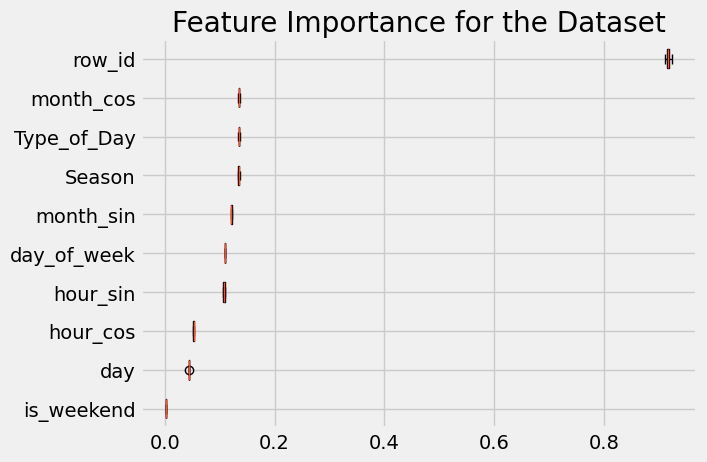

In [73]:
from sklearn.inspection import permutation_importance

result = permutation_importance(lgbm, X.values, y, n_repeats=10, random_state=42)

perm_imp_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_imp_idx].T, vert=False, labels=X.columns[perm_imp_idx])
plt.title('Feature Importance for the Dataset')

plt.show()

In [74]:
test.values

array([[ 9.49930000e+04,  1.00000000e+00,  5.40302306e-01, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 9.49940000e+04,  1.00000000e+00,  5.40302306e-01, ...,
         9.65925826e-01,  0.00000000e+00,  1.00000000e+00],
       [ 9.49950000e+04,  1.00000000e+00,  5.40302306e-01, ...,
         8.66025404e-01,  0.00000000e+00,  1.00000000e+00],
       ...,
       [ 1.21294000e+05,  3.10000000e+01, -6.53643621e-01, ...,
         7.07106781e-01, -5.00000000e-01,  8.66025404e-01],
       [ 1.21295000e+05,  3.10000000e+01, -6.53643621e-01, ...,
         8.66025404e-01, -5.00000000e-01,  8.66025404e-01],
       [ 1.21296000e+05,  3.10000000e+01, -6.53643621e-01, ...,
         9.65925826e-01, -5.00000000e-01,  8.66025404e-01]])

In [75]:
predicted_test = XGBRF.predict(test.values)
predicted_test

array([1777.4381, 1547.3185, 1451.0945, ..., 2279.1543, 2227.557 ,
       2080.8674], dtype=float32)

In [76]:
final_test = predicted_test + z
final_test

array([2024.8888, 1794.7692, 1698.5452, ..., 2526.605 , 2475.0076,
       2328.318 ], dtype=float32)

In [77]:
final_test = predicted_test + z
final_test

array([2024.8888, 1794.7692, 1698.5452, ..., 2526.605 , 2475.0076,
       2328.318 ], dtype=float32)

In [79]:
SS = submission
print(SS)

       row_id       energy
0       94993  1702.995014
1       94994  1702.995014
2       94995  1702.995014
3       94996  1702.995014
4       94997  1702.995014
...       ...          ...
26299  121292  1702.995014
26300  121293  1702.995014
26301  121294  1702.995014
26302  121295  1702.995014
26303  121296  1702.995014

[26304 rows x 2 columns]


In [80]:
SS['energy'] = final_test
SS['energy']

0        2024.888794
1        1794.769165
2        1698.545166
3        1643.004639
4        1605.140137
            ...     
26299    2641.618652
26300    2553.651855
26301    2526.604980
26302    2475.007568
26303    2328.318115
Name: energy, Length: 26304, dtype: float32